# Monte Carlo Methods

In this notebook, you will write your own implementations of many Monte Carlo (MC) algorithms. 

While we have provided some starter code, you are welcome to erase these hints and write your code from scratch.

# Part 0: Explore BlackjackEnv

We begin by importing the necessary packages.

In [ ]:
from plot_utils import plot_blackjack_values, plot_policy
import sys
import gym
import math
import numpy as np
from collections import defaultdict
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
%matplotlib inline


Use the code cell below to create an instance of the [Blackjack](https://github.com/openai/gym/blob/master/gym/envs/toy_text/blackjack.py) environment.

In [ ]:
env = gym.make('Blackjack-v0')


Each state is a 3-tuple of:
- the player's current sum $\in \{0, 1, \ldots, 31\}$,
- the dealer's face up card $\in \{1, \ldots, 10\}$, and
- whether or not the player has a usable ace (`no` $=0$, `yes` $=1$).

The agent has two potential actions:

```
    STICK = 0
    HIT = 1
```
Verify this by running the code cell below.

In [ ]:
print(env.observation_space)
print(env.action_space)


Execute the code cell below to play Blackjack with a random policy.  

(_The code currently plays Blackjack three times - feel free to change this number, or to run the cell multiple times.  The cell is designed for you to get some experience with the output that is returned as the agent interacts with the environment._)

In [ ]:
state = env.reset()
print(state)
action = env.action_space.sample()
print(action)
print(env.step(action))


In [ ]:
for i_episode in range(3):
    state = env.reset()
    while True:
        print(state)
        action = env.action_space.sample()
        state, reward, done, info = env.step(action)
        if done:
            print('End game! Reward: ', reward)
            print('You won :)\n') if reward > 0 else print('You lost :(\n')
            break


### Part 1: MC Prediction

In this section, you will write your own implementation of MC prediction (for estimating the action-value function).  

We will begin by investigating a policy where the player _almost_ always sticks if the sum of her cards exceeds 18.  In particular, she selects action `STICK` with 80% probability if the sum is greater than 18; and, if the sum is 18 or below, she selects action `HIT` with 80% probability.  The function `generate_episode_from_limit_stochastic` samples an episode using this policy. 

The function accepts as **input**:
- `bj_env`: This is an instance of OpenAI Gym's Blackjack environment.

It returns as **output**:
- `episode`: This is a list of (state, action, reward) tuples (of tuples) and corresponds to $(S_0, A_0, R_1, \ldots, S_{T-1}, A_{T-1}, R_{T})$, where $T$ is the final time step.  In particular, `episode[i]` returns $(S_i, A_i, R_{i+1})$, and `episode[i][0]`, `episode[i][1]`, and `episode[i][2]` return $S_i$, $A_i$, and $R_{i+1}$, respectively.

In [ ]:
def generate_episode_from_limit_stochastic(bj_env):
    episode = []
    state = bj_env.reset()
    while True:
        probs = [0.8, 0.2] if state[0] > 18 else [0.2, 0.8]
        action = np.random.choice(np.arange(2), p=probs)
        next_state, reward, done, info = bj_env.step(action)
        episode.append((state, action, reward))
        state = next_state
        if done:
            break
    return episode


Execute the code cell below to play Blackjack with the policy. 

(*The code currently plays Blackjack three times - feel free to change this number, or to run the cell multiple times.  The cell is designed for you to gain some familiarity with the output of the `generate_episode_from_limit_stochastic` function.*)

In [ ]:
# episode = generate_episode_from_limit_stochastic(env)
# print('Episode = ',episode,'\n\n')

# for i in range(len(episode)-1, -1, -1): # Testing each state / action from the end of the episode with index i = integer. Is it earliest?
#     earlier_found = False
#     print('============================\n\nTesting for i = ', episode[i], '\n===================================')
#     print('Earlier_found is ', earlier_found)
#     for j in range(0,len(episode)):  # Walking through each state / action in the episode, from beginning
#         print('Now INSIDE "testing for each j" loop\n---------------------------\n')
#         print('-------> j = ',j,', i = ',i, ', (j[i], j[1]) = ', (episode[j][0], episode[j][1]), ', (i[i], i[1]) = ',(episode[i][0], episode[i][1])  )
#         if (j < i): # for records up to the one before the current item being tested for earliest
#             print('\n----------->>> Inside conditional. j = ',j,', i = ',i)
#             print('j < i is ',(j < i))

#             # Inside conditional, know we're testing against an earlier state / action
#             if ((episode[j][0], episode[j][1]) == (episode[i][0], episode[i][1])): # if the state / action pair exists
#                 earlier_found = True
#                 print('Earlier_found is ', earlier_found)
#                 print(' --------->>>>>>  Found earlier pair\n')
#             print('Finished with comparison for j < i, j = ',j,', i = ',i)
#         print('Finished looping through if (j < i) "if" statement')
#     print('\nFinished "looping through all j" for i.\nEarlier_found is ', earlier_found, '\n--------------------------\n\n')

#     # Now finished looping thought all previous
#     if (earlier_found):  # Earlier instance found, do nothing, update will happen when that instance is tested
#         print('Earlier found, do nothing\n____________________________________\n')
#     else:
#         print('Is earliest, update counters\n____________________________________\n')


In [ ]:
episode = generate_episode_from_limit_stochastic(env)
print('Episode = ', episode, '\n\n')
len(episode)
for i in range(len(episode)-1, -1, -1):
    for j in range(0, len(episode)):
        if (j < i):
            print(j < i)
            print('i,j = ', i, j)


Now, you are ready to write your own implementation of MC prediction.  Feel free to implement either first-visit or every-visit MC prediction; in the case of the Blackjack environment, the techniques are equivalent.

Your algorithm has three arguments:
- `env`: This is an instance of an OpenAI Gym environment.
- `num_episodes`: This is the number of episodes that are generated through agent-environment interaction.
- `generate_episode`: This is a function that returns an episode of interaction.
- `gamma`: This is the discount rate.  It must be a value between 0 and 1, inclusive (default value: `1`).

The algorithm returns as output:
- `Q`: This is a dictionary (of one-dimensional arrays) where `Q[s][a]` is the estimated action value corresponding to state `s` and action `a`.



In [ ]:
# # My first visit solution
# #################  Calculate backward
# #########################################################
#
# def mc_prediction_q(env, num_episodes, generate_episode, gamma=1.0):
#     # initialize empty dictionaries of arrays

#     # keep sum of future returns from a certain state / action pair at first encounter
#     returns_sum = defaultdict(lambda: np.zeros(env.action_space.n)) # Initialise returns_sum[s][a]

#     # Count how many times a certain state / action pair was encountered for the first time - with returns_sum, can get average state value
#     N = defaultdict(lambda: np.zeros(env.action_space.n)) # Initialise N[s][a]

#     # The table of states and actions - average used
#     Q = defaultdict(lambda: np.zeros(env.action_space.n))


#     # loop over episodes
#     for i_episode in range(1, num_episodes+1):
#         # monitor progress
#         if i_episode % 1000 == 0:
#             print("\rEpisode {}/{}.".format(i_episode, num_episodes), end="")
#             sys.stdout.flush()

# ##################################################################
#         ## Remember:
#         # episode[i][0] = Si,
#         # episode[i][1] = Ai,
#         # episode[i][2] = R(i+1)
#         # So: [episode[i][0]][episode[i][1]] is [s][a], for Q[s][a]
# ##################################################################
#         # Play a round - i.e., an episode
# ########################################################################
# ########################################################################
#         # Play a round - i.e., an episode
#         episode = generate_episode_from_limit_stochastic(env) # "episode" now contains one full episode
#         episode_returns = 0 # initialise cumulative reward function for episode

#         for i in range(len(episode)-1, -1, -1):
#             earlier_found = False # Step backward over state / action pairs in episode
#             episode_returns = gamma*episode_returns + episode[i][2] # Add gamma to make function generalised;  add reward function for next state - R(i+1)
#             # Now check for first visit
#             ###########################
#             for j in range(0,len(episode)):  # Walking through each state / action in the episode, from beginning
#                 if (j < i): # for records up to the one before the current item being tested for earliest
#                     if ((episode[j][0], episode[j][1]) == (episode[i][0], episode[i][1])): # if the state / action pair exists
#                         earlier_found = True
#             if (earlier_found == False):
#                 returns_sum[(episode[i][0])][episode[i][1]] += episode_returns # Add to sum of state / action pair the cumulative episode return
#                 N[(episode[i][0])][episode[i][1]] += 1 # Counts number of first visits to state / action pair

# # Remember Q[s][a] is the estimated action value corresponding to state s and action a
#     for i in N: # Loop over the states that actually occurred
#         for j in range(0,env.action_space.n):
#             if returns_sum[i][j] != 0: # Avoid divide zero  by zero = nan
#                 Q[i][j]= returns_sum[i][j] / N[i][j] #

#     return Q


In [ ]:
# My first visit solution
# Calculate rewards full function, then loop forward
#########################################################################

def mc_prediction_q(env, num_episodes, generate_episode, gamma=1.0):
    # initialize empty dictionaries of arrays

    # keep sum of future returns from a certain state / action pair at first encounter
    # Initialise returns_sum[s][a]
    returns_sum = defaultdict(lambda: np.zeros(env.action_space.n))

    # Count how many times a certain state / action pair was encountered for the first time - with returns_sum, can get average state value
    N = defaultdict(lambda: np.zeros(env.action_space.n))  # Initialise N[s][a]

    # The table of states and actions - average used
    Q = defaultdict(lambda: np.zeros(env.action_space.n))

    # loop over episodes
    for i_episode in range(1, num_episodes+1):
        # monitor progress
        if i_episode % 1000 == 0:
            print("\rEpisode {}/{}.".format(i_episode, num_episodes), end="")
            sys.stdout.flush()

##################################################################
        # Remember:
        # episode[i][0] = Si,
        # episode[i][1] = Ai,
        # episode[i][2] = R(i+1)
        # So: [episode[i][0]][episode[i][1]] is [s][a], for Q[s][a]

########################################################################
########################################################################
        # Play a round - i.e., an episode
        episode = generate_episode(env)
        # episode = generate_episode_from_limit_stochastic(env) # "episode" now contains one full episode

        # Calculate full dictionary of discounted rewards for each state / action pair
        # Initialise cumulative_reward dictionary
        cumulative_reward = defaultdict(lambda: np.zeros(len(episode)))
        # If only one pair, assign Ri+1 to first item in dictionary
        cumulative_reward[len(episode)-1] = episode[len(episode)-1][2]
        if len(episode) > 1:  # If there are more than one pairs in episode, calculate discounted values, populate cumulative_rewards
            for i in range((len(episode)-2), -1, -1):
                cumulative_reward[i] = episode[i][2] + \
                    gamma*cumulative_reward[i+1]

        # Now check for first visit

        for i in range(0, len(episode)):  # Step through pairs from beginning
            is_earliest = True  # Is a first visit, unless proven otherwise
            # Walking through each state / action in the episode, from beginning
            for j in range(0, len(episode)):
                if (j < i):  # If there are pairs preceding the current one
                    # if the state / action pair exists
                    if ((episode[j][0], episode[j][1]) == (episode[i][0], episode[i][1])):
                        is_earliest = False  # Earlier instance of pair found
            if (is_earliest):
                # Add to sum of state / action pair the cumulative episode return
                returns_sum[(episode[i][0])][episode[i]
                                             [1]] += cumulative_reward[i]
                # Counts number of first visits to state / action pair
                N[(episode[i][0])][episode[i][1]] += 1

# Remember Q[s][a] is the estimated action value corresponding to state s and action a
    for i in N:  # Loop over the states that actually occurred
        for j in range(0, env.action_space.n):
            if returns_sum[i][j] != 0:  # Avoid divide zero  by zero = nan
                Q[i][j] = returns_sum[i][j] / N[i][j]

    return Q


In [ ]:
# # My all visits solution

# def mc_prediction_q(env, num_episodes, generate_episode, gamma=1.0):
#     # initialize empty dictionaries of arrays

#     # keep sum of future returns from a certain state / action pair at first encounter
#     returns_sum = defaultdict(lambda: np.zeros(env.action_space.n)) # Initialise returns_sum[s][a]

#     # Count how many times a certain state / action pair was encountered for the first time - with returns_sum, can get average state value
#     N = defaultdict(lambda: np.zeros(env.action_space.n)) # Initialise N[s][a]

#     # The table of states and actions - average used
#     Q = defaultdict(lambda: np.zeros(env.action_space.n))


#     # loop over episodes
#     for i_episode in range(1, num_episodes+1):
#         # monitor progress
#         if i_episode % 1000 == 0:
#             print("\rEpisode {}/{}.".format(i_episode, num_episodes), end="")
#             sys.stdout.flush()

# ##################################################################
#         ## Remember:
#         # episode[i][0] = Si,
#         # episode[i][1] = Ai,
#         # episode[i][2] = R(i+1)
#         # So: [episode[i][0]][episode[i][1]] is [s][a], for Q[s][a]
# ##################################################################
#         # Play a round - i.e., an episode
#         episode = generate_episode_from_limit_stochastic(env) # "episode" now contains one full episode
#         episode_returns = 0 # initialise cumulative reward function for episode

#         for i in range(len(episode)-1, -1, -1): # Step backward over state / action pairs in episode
#             episode_returns = gamma*episode_returns + episode[i][2] # Add gamma to make function generalised;  add reward function for next state - R(i+1)
#             returns_sum[(episode[i][0])][episode[i][1]] += episode_returns # Add to sum of state / action pair the cumulative episode return
#             N[(episode[i][0])][episode[i][1]] += 1 # Counts number of first visits to state / action pair

# # Remember Q[s][a] is the estimated action value corresponding to state s and action a
#     for i in N: # Loop over the states that actually occurred
#         for j in range(0,env.action_space.n):
#             if returns_sum[i][j] != 0: # Avoid divide zero  by zero = nan
#                 Q[i][j]= returns_sum[i][j] / N[i][j] #

#     return Q


Use the cell below to obtain the action-value function estimate $Q$.  We have also plotted the corresponding state-value function.

To check the accuracy of your implementation, compare the plot below to the corresponding plot in the solutions notebook **Monte_Carlo_Solution.ipynb**.

In [ ]:
# obtain the action-value function
Q = mc_prediction_q(env, 50, generate_episode_from_limit_stochastic)
print(Q)

# obtain the corresponding state-value function
V_to_plot = dict((k, (k[0] > 18)*(np.dot([0.8, 0.2], v)) + (k[0] <= 18)*(np.dot([0.2, 0.8], v)))
                 for k, v in Q.items())

# plot the state-value function
plot_blackjack_values(V_to_plot)


# Part 2: MC Control

In this section, you will write your own implementation of constant-$\alpha$ MC control.  

Your algorithm has four arguments:
- `env`: This is an instance of an OpenAI Gym environment.
- `num_episodes`: This is the number of episodes that are generated through agent-environment interaction.
- `alpha`: This is the step-size parameter for the update step.
- `gamma`: This is the discount rate.  It must be a value between 0 and 1, inclusive (default value: `1`).

The algorithm returns as output:
- `Q`: This is a dictionary (of one-dimensional arrays) where `Q[s][a]` is the estimated action value corresponding to state `s` and action `a`.
- `policy`: This is a dictionary where `policy[s]` returns the action that the agent chooses after observing state `s`.

(_Feel free to define additional functions to help you to organize your code._)

In [1]:
from plot_utils import plot_blackjack_values, plot_policy
import sys
import gym
import math
import numpy as np
from collections import defaultdict
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
%matplotlib inline


In [2]:
env = gym.make('Blackjack-v0')

In [3]:
# Generate an episode based on a policy
def generate_episode_from_policy(env, policy={}):
    # env: provided environment (blackjack for now)
    # policy = dictionary of states for which there exists a policy, and the policy (i.e., 0 or 1 for that state-tuple).  
    # Defaults to empty dictionary.
    episode = []  # Begin with empty episodes
    state = env.reset()  # Reset environment, get a random state.

    while True:  # Checks for 'done'
        # Now define action for policy
        if not(state in policy):  # If current state does not exist in policy dictionary
            action = env.action_space.sample()  # Get a random action
            next_state, reward, done, info = env.step(action)  # Take one step in the environment
        else:  # There exists an action in the policy for that state, so use it
            action = policy[state]  # Select the policy action for the state
            next_state, reward, done, info = env.step(action)  # Take one step in the environment
        episode.append((state, action, reward))  # Append the new step to the episode
        state = next_state  
        if done:  #  The next step returned 'done'
            break
    return episode


In [4]:
def epsilon_greedy(Q, epsilon):
    policy = {}  # Initialise empty dictionary
    for key in Q:  # Iterate over dictionary Q
        p = np.random.rand()  # Generate random float between 0 and 1
        if p > epsilon: # Pick the optimal policy
            policy[key] = np.argmax(Q[key]) # get the array of nA estimates, get index of max action, make that the policy
        else:
            policy[key] = env.action_space.sample()  # Pick a random action for the policy
    return policy

In [5]:
# Define main control function
def mc_control(env, num_episodes, alpha, gamma=1.0):
    nA = env.action_space.n
    # initialize empty dictionary of arrays
    Q = defaultdict(lambda: np.zeros(nA))
    policy = {}  # Initialise empty dictionary
    # loop over episodes
    for i_episode in range(1, num_episodes+1):
        # monitor progress
        if i_episode % 1000 == 0:
            print("\rEpisode {}/{}.".format(i_episode, num_episodes), end="")
            sys.stdout.flush()


# ###  The code below for exploration / exploitation works            

#         # Allow random exploration, balance exploration with exploitation
#         epsilon = 0.05  # Pick epsilon between 0.05 and 0.1 normally
#         epsilon_i_episode = epsilon * (1 - i_episode/(num_episodes+1))
#         policy = epsilon_greedy(Q, epsilon_i_episode)  # Update policy for this round / episode
#         episode = generate_episode_from_policy(env, policy)
# ### End - code works        


############ NO!!!!!  This experiment does not guaranteee convergence with ϵ = 0.  Here is the set of conditions necessary:
# In particular, let \epsilon_iϵ i correspond to the ii-th time step. Then, to satisfy the GLIE conditions, we need 
# only set \epsilon_iϵ i such that:
# * ϵi > 0 for all time steps ii, and
# * ϵi decays to zero in the limit as the time step ii approaches infinity 
# (that is, lim i→∞  ϵi = 0)
# The experiment to exploit for the last x% used 0 as epsilon.  This is wrong.

        # #########################################################
        # Experimenting with initial aggressive exploration to hunt global optima, then exploitation
        # Allow random exploration, balance exploration with exploitation
        epsilon = 0.08  # Pick epsilon between 0.05 and 0.1 normally
        if (i_episode)/(num_episodes*.8) < 1: # Hunt for global optima for first xx% of iterations
            epsilon_i_episode = epsilon * (1 - i_episode/(num_episodes*.8))
        else:
            epsilon_i_episode = 0.01   # Exclusively exploit to converge policy to optimum.  See comments - this may not be zero
        policy = epsilon_greedy(Q, epsilon_i_episode)  # Update policy for this round / episode
        # Use the greedy policy to generate episode
        episode = generate_episode_from_policy(env, policy)
        ######################################## End experiment

        # Calculate full dictionary of discounted rewards for each state / action pair
        # Initialise cumulative_reward dictionary
        cumulative_reward = defaultdict(lambda: np.zeros(len(episode)))
        # If only one pair, assign Ri+1 to first item in dictionary
        cumulative_reward[len(episode)-1] = episode[len(episode)-1][2]
        if len(episode) > 1:  # If there are more than one pairs in episode, calculate discounted values, populate cumulative_rewards
            for i in range((len(episode)-2), -1, -1):
                cumulative_reward[i] = episode[i][2] + \
                    gamma*cumulative_reward[i+1]

        # ##################################################################
        #         ## Remember:
        #         # episode[i][0] = Si,
        #         # episode[i][1] = Ai,
        #         # episode[i][2] = R(i+1)
        #         # So: [episode[i][0]][episode[i][1]] is [s][a], for Q[s][a]
        # ##################################################################

        # Now check for first visit
        for t in range(0, len(episode)):  # Step through state / action pairs from beginning
            is_earliest = True  # Is a first visit, unless proven otherwise
            # Walking through each state / action in the episode, from beginning
            # TODO ## This checks only for the two actions of blackjack - generalise to nA actions
            for j in range(0, len(episode)):
                if (j < t):  # If there are pairs preceding the current one
                    # if the state / action pair exists
                    if ((episode[j][0], episode[j][1]) == (episode[t][0], episode[t][1])):
                        is_earliest = False  # Earlier instance of pair found
            if (is_earliest):
                # Q[St, At] += alpha*(Gt - Q[St, At])
                Q[episode[t][0]][episode[t][1]] += alpha * \
                    (cumulative_reward[t] - Q[episode[t][0]][episode[t][1]])

    policy = epsilon_greedy(Q,0)  # return policy using greedy - max(Q)
    return policy, Q


Use the cell below to obtain the estimated optimal policy and action-value function.  Note that you should fill in your own values for the `num_episodes` and `alpha` parameters.

In [6]:
# obtain the estimated optimal policy and action-value function
policy, Q = mc_control(env, 50_000_000, 0.02)  # (env, num_episodes, alpha)


Episode 50000000/50000000.

Next, we plot the corresponding state-value function.

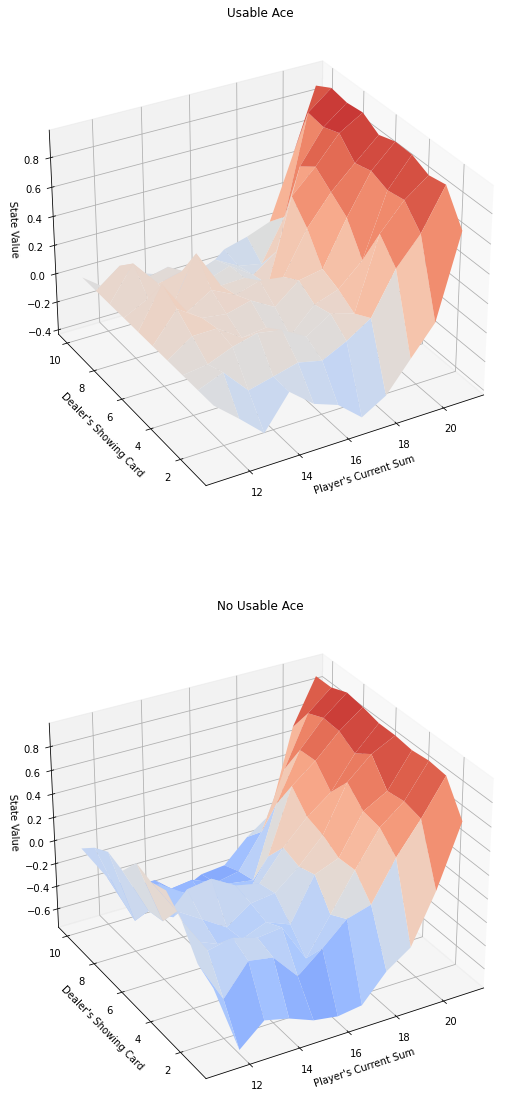

In [7]:
# obtain the corresponding state-value function
V = dict((k, np.max(v)) for k, v in Q.items())

# plot the state-value function
plot_blackjack_values(V)


Finally, we visualize the policy that is estimated to be optimal.

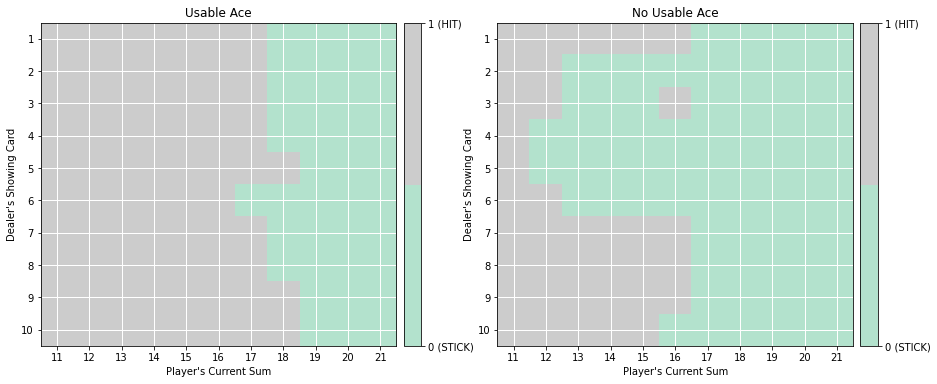

In [8]:
# plot the policy
plot_policy(policy)


The **true** optimal policy $\pi_*$ can be found in Figure 5.2 of the [textbook](http://go.udacity.com/rl-textbook) (and appears below).  Compare your final estimate to the optimal policy - how close are you able to get?  If you are not happy with the performance of your algorithm, take the time to tweak the decay rate of $\epsilon$, change the value of $\alpha$, and/or run the algorithm for more episodes to attain better results.

![True Optimal Policy](images/optimal.png)